In [1]:
# %%
import numpy as np
import pandas as pd
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.area_opt.tree_area_evaluator import TreeAreaEvaluator

In [4]:
from src.area_opt.get_tree_area import get_tree_area
from src.area_opt.create_distance_constraints import create_distance_constraints, test_constraints
from src.area_opt.optimize_tree_area import optimize_tree_area

from src.pairs.complete_meeting_analysis import complete_meeting_analysis
from src.pairs.create_chronological_meetings import create_chronological_meetings
from src.pairs.optimize_grandchild_parent_distance import optimize_grandchild_parent_distance
from src.pairs.optimize_grandchild_pair_distance import optimize_grandchild_pair_distance
from src.pairs.find_optimal_pairs import find_optimal_pairs
from src.pairs.extract_optimal_times_from_pairs import extract_optimal_times_from_pairs
from src.pairs.create_tree_from_pairs import create_tree_from_pairs


from src.pairs.extract_pairs_from_chronology import (
    extract_pairs_from_chronology,
    get_pair_details,
    analyze_pair_statistics,
    export_pairs_to_csv
)
from src.pairs.create_meeting_chronology import (
    create_meeting_chronology,
    export_chronology_to_csv,
    get_meeting_recommendations
)
from src.pairs.build_distance_tables import (
    build_grandchild_distance_tables,
    build_grandchild_parent_distance_tables
)
from src.pairs.compute_convergence_tables import (
    compute_distance_derivative_table,
    compute_grandchild_parent_convergence_table
)
from src.pairs.find_converging_pairs import (
    find_converging_grandchild_pairs,
    find_converging_grandchild_parent_pairs
)
from src.pairs.extract_optimal_dt_from_pairs import (
    extract_optimal_dt_from_pairs,
    create_optimized_tree_from_pairs,
    compare_trees_distances
)

In [5]:
def draw_rk(pendulum, state, control, N = 50, total_dt=0.01, show=False):
    poses = [state]
    dt = total_dt/N
    for i in range(1, N+1):
        poses.append(pendulum.step(poses[-1], control, dt))

    return np.array(poses)

In [16]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.05,
    max_control=2.0
)

init_position = np.array([np.pi/2 , 2])

cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.02,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 15)
)
cfg.validate()

True

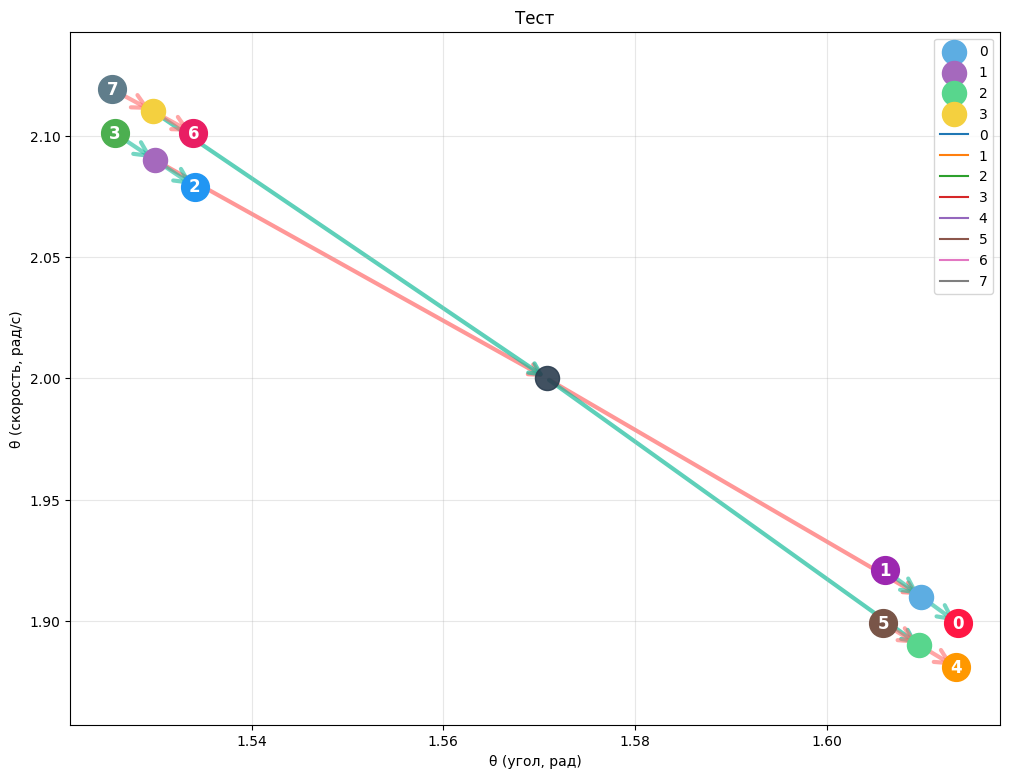

In [17]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")


poses = []
# dts = [0.01, 0.005, 0.003, 0.003, 0.01, 0.006, 0.003, 0.003]
dts = [1.5, -0.07897676, 0.07897674, -0.9, 0.00, 0.00, 0.00, 0.000] 
dts = np.array(dts) *0

for i in range(len(grandchildren)):
    parent_pos = children[grandchildren[i]['parent_idx']]['position']
    sign = grandchildren[i]['dt'] / grandchildren[i]['dt_abs']
    control = grandchildren[i]['control']
    poses_1 = draw_rk(pendulum, state=parent_pos, control=control, total_dt=dts[i])

    plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{i}')

plt.legend()


Создано дерево с 4 парами


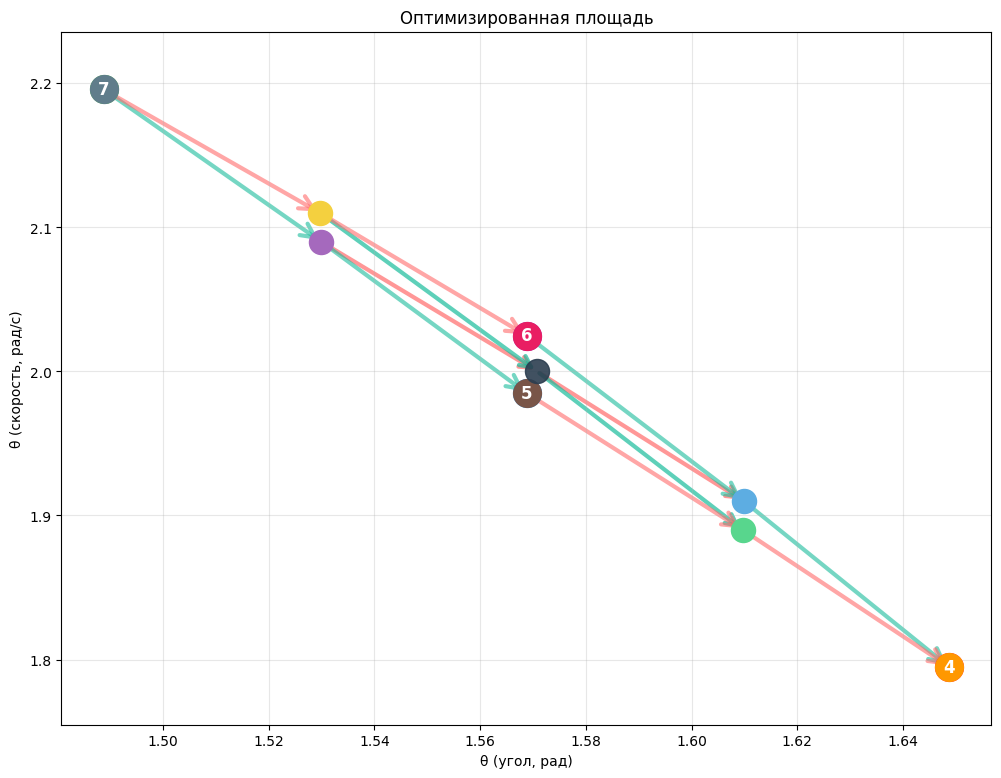

In [18]:
pairs = find_optimal_pairs(tree, show=False)
# Полный дебаг
result = create_tree_from_pairs(tree, pendulum, cfg, show=False)

# Проверка результата
if result and result['success']:
    paired_tree = result['optimized_tree']
    print(f"Создано дерево с {result['stats']['pairs_found']} парами")
else:
    print(f"Ошибка: {result['error'] if result else 'критическая ошибка'}")

visualize_spore_tree(paired_tree, "Оптимизированная площадь")

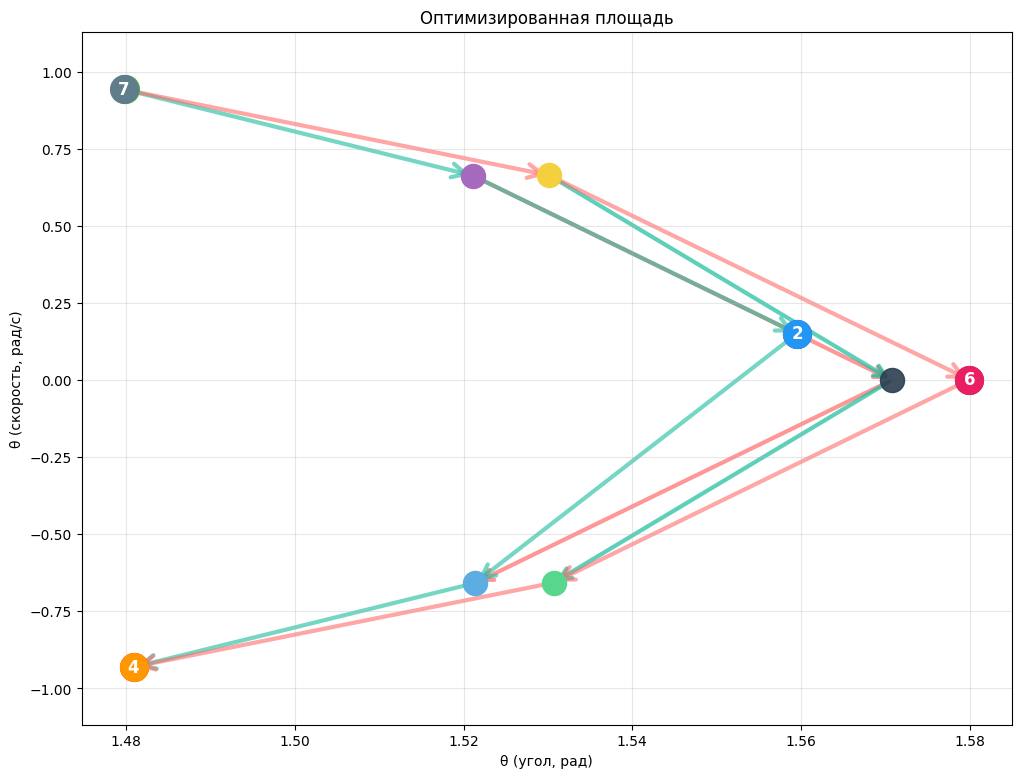

In [9]:
result = optimize_tree_area(
            tree=paired_tree,
            pairs=pairs, 
            pendulum=pendulum,
            constraint_distance=1e-4,  # Максимальное расстояние между парами
            max_iterations=1200,
            dt_bounds=(0.001, 0.15),
            show=False  # Показать весь процесс
        )

optimized_tree = result['optimized_tree']
visualize_spore_tree(optimized_tree, "Оптимизированная площадь")

In [10]:
pairs = find_optimal_pairs(tree, show=False)
for pair in pairs:
    print(pair)

(0, 4, {'type': 'grandchild', 'partner': 'gc_4', 'partner_idx': 4, 'distance': 7.855367300016406e-16, 'time_gc': 0.009499352105276589, 'time_partner': 0.007115549769649815, 'meeting_time': 0.009499352105276589, 'who_waits': 'gc'})
(1, 2, {'type': 'grandchild', 'partner': 'gc_2', 'partner_idx': 2, 'distance': 6.839178858866263e-08, 'time_gc': -0.027484981627984847, 'time_partner': 0.00511446470296731, 'meeting_time': 0.027484981627984847, 'who_waits': 'gc'})
(3, 7, {'type': 'grandchild', 'partner': 'gc_7', 'partner_idx': 7, 'distance': 4.847302891456678e-16, 'time_gc': -0.009502791935789416, 'time_partner': -0.007119770492267891, 'meeting_time': 0.009502791935789416, 'who_waits': 'gc'})
(5, 6, {'type': 'grandchild', 'partner': 'gc_6', 'partner_idx': 6, 'distance': 2.378820652968194e-07, 'time_gc': -0.024540299001261177, 'time_partner': 0.024540295154647312, 'meeting_time': 0.024540299001261177, 'who_waits': 'gc'})


In [11]:
extraction = extract_optimal_times_from_pairs(pairs, tree, show=False)
print(extraction['dt_children'])
print(extraction['dt_grandchildren'])

dt_children_abs = np.abs(extraction['dt_children'])
dt_grandchildren_abs = np.abs(extraction['dt_grandchildren'])

[ 0.02 -0.02  0.02 -0.02]
[ 0.00949935 -0.02748498  0.00511446 -0.00950279  0.00711555 -0.0245403
  0.0245403  -0.00711977]


area 0.00019113023644430627


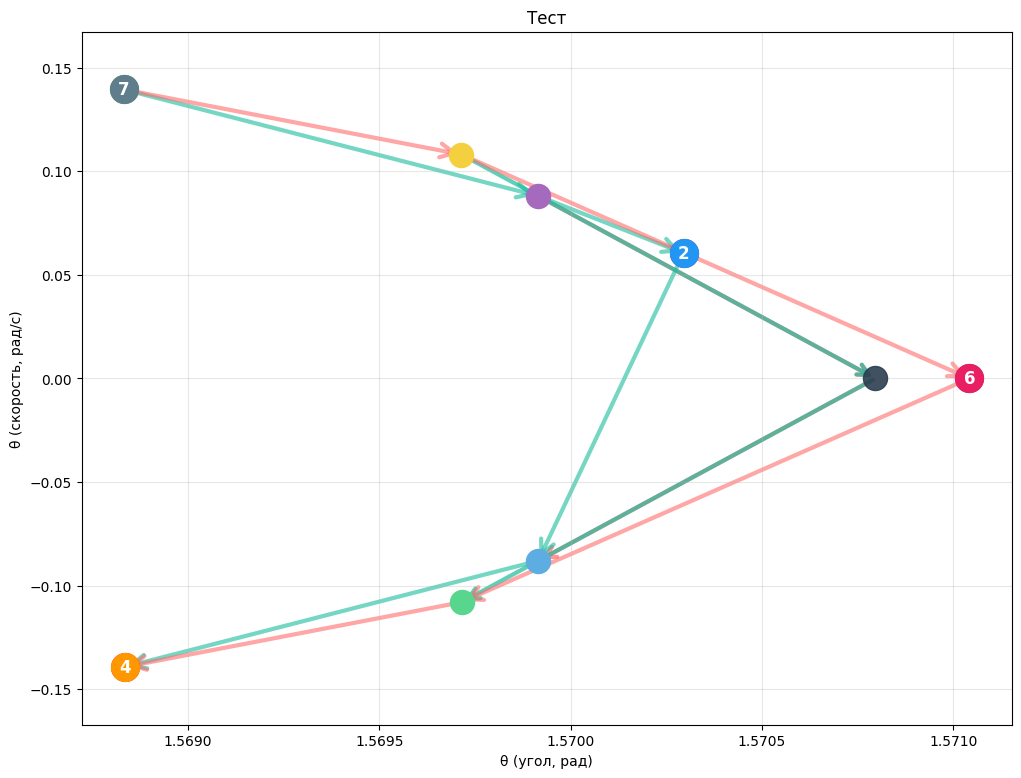

In [12]:
optimized_tree = SporeTree(
    pendulum=pendulum,  # Тот же маятник
    config=cfg,         # Та же конфигурация  
    dt_children=dt_children_abs,
    dt_grandchildren=dt_grandchildren_abs,
    show=False  # Без дебага при создании
        )

print('area', get_tree_area(optimized_tree))
visualize_spore_tree(optimized_tree, "Тест")

In [13]:
# Создать констрейнты
constraints, info = create_distance_constraints(pairs, tree, pendulum, constraint_distance=1e-5)

# Для scipy.optimize.minimize
scipy_constraints = [{'type': 'ineq', 'fun': func} for func in constraints]

In [14]:
# Простой запуск оптимизации площади

# Импорты

# 1. Найти пары (у вас уже есть tree, pendulum)
pairs = find_optimal_pairs(tree, show=False)

if pairs is None:
    print("Пары не найдены!")
else:
    print(f"Найдено {len(pairs)} пар")
    
    # 2. Запустить оптимизацию площади
    result = optimize_tree_area(
        tree=tree,
        pairs=pairs, 
        pendulum=pendulum,
        constraint_distance=1e-7,  # Максимальное расстояние между парами
        show=True  # Показать весь процесс
    )
    
    # 3. Проверить результат
    if result is None:
        print("Оптимизация не удалась!")
    elif not result['success']:
        print(f"Оптимизация не сошлась: {result.get('error', 'неизвестная ошибка')}")
    else:
        print(f"Успех! Площадь улучшена на {result['improvement_percent']:.2f}%")
        print(f"Исходная площадь: {result['original_area']}")
        print(f"Новая площадь: {result['optimized_area']}")
        
        # Получить оптимизированное дерево
        optimized_tree = result['optimized_tree']
        
        # Визуализация
        if optimized_tree:
            visualize_spore_tree(optimized_tree, "Оптимизированная площадь")

Найдено 4 пар
ОПТИМИЗАЦИЯ ПЛОЩАДИ ДЕРЕВА С КОНСТРЕЙНТАМИ ПАР
TreeAreaEvaluator создан
Исходная площадь дерева: 0.000040
Создание констрейнтов расстояний...
Создано 4 констрейнтов
Начальное приближение: [0.02  0.02  0.02  0.02  0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002]
Границы dt: (0.001, 0.1)
Метод оптимизации: SLSQP
Максимум итераций: 1000

Тестирование начального приближения...
Начальная целевая функция: -0.000040 (площадь: 0.000040)
Проверка evaluator: OK
Начальные констрейнты: 0/4 выполнено

Запуск оптимизации...


C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.014952182066082457
            Iterations: 153
            Function evaluations: 2185
            Gradient evaluations: 149
Оптимизация завершена:
  Успех: False
  Сообщение: Positive directional derivative for linesearch
  Итераций: 153
  Вызовов функции: 2185
Оптимизация не сошлась: Positive directional derivative for linesearch
Оптимизация не сошлась: Positive directional derivative for linesearch


In [15]:
pairs = find_optimal_pairs(tree, show=False)
result = optimize_tree_area(
            tree=tree,
            pairs=pairs, 
            pendulum=pendulum,
            constraint_distance=1e-6,  # Максимальное расстояние между парами
            show=False  # Показать весь процесс
        )

optimized_tree = result['optimized_tree']
visualize_spore_tree(optimized_tree, "Оптимизированная площадь")

KeyError: 'optimized_tree'

In [ ]:
import time
start_time = time.time()
for i in range(1): 
    result = optimize_tree_area(
            tree=tree,
            pairs=pairs, 
            pendulum=pendulum,
            constraint_distance=1e-6,  # Максимальное расстояние между парами
            show=False  # Показать весь процесс
        )
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Time taken: 0.36331844329833984 seconds


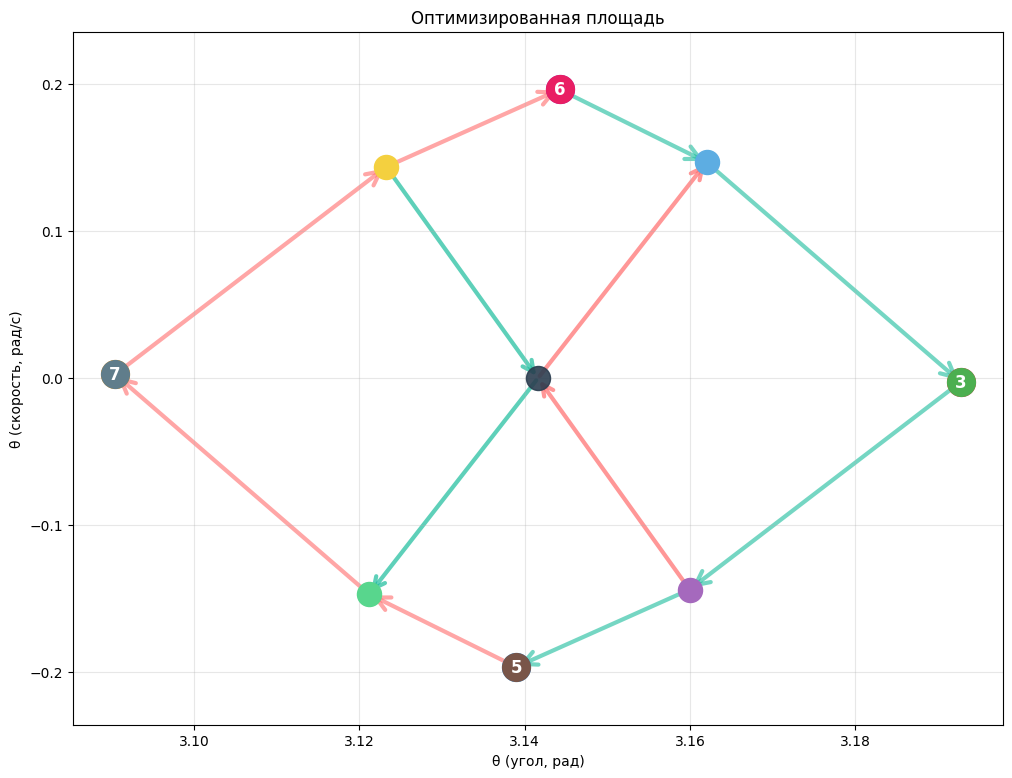

In [ ]:
optimized_tree = result['optimized_tree']
visualize_spore_tree(optimized_tree, "Оптимизированная площадь")